In [6]:
from src.preprocessing.preprocess_data_deeplab import get_preprocessed_data, get_google_data, get_massa_data, get_deepglobe_data
import numpy as np

N_FILES = 4000

deepglobe_path = '/workspace/Comp/Datasets/DeepGlobe/train/'

print('-' * 100)
print('Getting DeepGlobe data')
deep_train_x, deep_train_y, deep_val_x, deep_val_y = get_deepglobe_data(deepglobe_path, N_FILES)
print(deep_train_x.shape, deep_train_y.shape, deep_val_x.shape, deep_val_y.shape)

train_path = "/workspace/Comp/Datasets/Project/training/"


print('-' * 100)
print('Getting Project data')
(train_x, train_y), (val_x, val_y), (ori_val_x, ori_val_y) = get_preprocessed_data(path=train_path)
print(train_x.shape, train_y.shape, val_x.shape, val_y.shape)

google_path = "/workspace/Comp/Datasets/Google/sampled/"

print('-' * 100)
print('Getting Google data')
google_train_x, google_train_y, google_val_x, google_val_y = get_google_data(google_path, N_FILES)
print(google_train_x.shape, google_train_y.shape, google_val_x.shape, google_val_y.shape)


massachusetts_path = "/workspace/Comp/Datasets/Massachussets/tiff/"

print('-' * 100)
print('Getting Massachussets data')
massa_train_x, massa_train_y, massa_val_x, massa_val_y = get_massa_data(massachusetts_path, N_FILES)
print(massa_train_x.shape, massa_train_y.shape, massa_val_x.shape, massa_val_y.shape)

# Concatenate datasets

print('-' * 30)
print('Concatenating datasets')
X_train = np.concatenate([train_x, deep_train_x, google_train_x, massa_train_x], axis=0)
Y_train = np.round(np.concatenate([train_y, deep_train_y, google_train_y, massa_train_y], axis=0))
X_val = np.concatenate([val_x, deep_val_x, google_val_x, massa_val_x], axis=0)
Y_val = np.round(np.concatenate([val_y, deep_val_y, google_val_y, massa_val_y], axis=0))

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)


----------------------------------------------------------------------------------------------------
Getting DeepGlobe data
Listing files
Filtering files
Choosing N_FILES
Getting masks
Preprocessing files
Opening cropped images...
Opening resized images...
Preprocessing images...
Splitting data into training and validation sets...
(8, 400, 400, 3) (8, 400, 400, 1) (2, 400, 400, 3) (2, 400, 400, 1)
----------------------------------------------------------------------------------------------------
Getting Project data
CHECK
(575, 400, 400, 3) (575, 400, 400, 1) (145, 400, 400, 3) (145, 400, 400, 1)
----------------------------------------------------------------------------------------------------
Getting Eliot data
Listing files
Choosing N_FILES
Getting masks
Preprocessing files
Opening cropped images...
Opening resized images...
Preprocessing images...
Splitting data into training and validation sets...
(8, 400, 400, 3) (8, 400, 400, 1) (2, 400, 400, 3) (2, 400, 400, 1)
--------------

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU, Precision, Recall, Fscore
from segmentation_models_pytorch.utils.losses import DiceLoss
import matplotlib.pyplot as plt
import os
import shutil

# Create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name='resnet152',
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid',
)

# Assuming you have already obtained your datasets as numpy arrays
# X_train, Y_train, X_val, Y_val

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).permute(0, 3, 1, 2)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).permute(0, 3, 1, 2)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# Set num of epochs
EPOCHS = 50

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = DiceLoss()


# define metrics
metrics = [
    IoU(threshold=0.5),
    Precision(threshold=0.5),
    Recall(threshold=0.5),
    Fscore(threshold=0.5),
]


# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0008, weight_decay=1e-4),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=1, eta_min=1e-6,
)

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

import matplotlib.pyplot as plt
import os

def save_validation_prediction_plot(model, val_loader, device, epoch, output_dir='./plots'):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    with torch.no_grad():
        # Plot the images
        fig, ax = plt.subplots(5, 3, figsize=(15, 25))

        i = 0
        for val_data in val_loader:
            val_images, val_masks = val_data
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            outputs = model(val_images)
            outputs = outputs.cpu().numpy()
            val_images = val_images.cpu().numpy()
            val_masks = val_masks.cpu().numpy()

            # Select the first image in the batch for visualization
            img = val_images[0].transpose(1, 2, 0)
            true_mask = val_masks[0].transpose(1, 2, 0)
            pred_mask = outputs[0].transpose(1, 2, 0)

            ax[i, 0].imshow(img)
            ax[i, 0].set_title("Input Image")
            ax[i, 0].axis('off')
            ax[i, 1].imshow(true_mask.squeeze(), cmap='gray')
            ax[i, 1].set_title("True Mask")
            ax[i, 1].axis('off')
            ax[i, 2].imshow(pred_mask.squeeze(), cmap='gray')
            ax[i, 2].set_title("Predicted Mask")
            ax[i, 2].axis('off')
            # Only show/save the first batch
            i += 1
            if i == 5:
                break
        # Save the plot
        plot_path = os.path.join(output_dir, f'epoch_{epoch + 1}.png')
        plt.savefig(plot_path)
        plt.close()


## Delete all predictions from predictions folder

directory = '/workspace/Comp/Road-Segmentation-Comp/predictions'

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):
    # Perform training & validation
    print('\nEpoch: {}'.format(i+1))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)
    # Save model if a better val IoU score is obtained
    if best_iou_score < valid_logs['fscore']:
        best_iou_score = valid_logs['fscore']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    
    # Reduce learning rate on plateau
    # lr_scheduler.step(valid_logs['dice_loss'])

    save_validation_prediction_plot(model, val_loader, DEVICE, i, output_dir='./predictions')
        
        

/workspace/Comp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Epoch: 1
valid: 100%|██████████| 73/73 [00:08<00:00,  8.81it/s, dice_loss - 0.4494, iou_score - 0.4193, precision - 0.553, recall - 0.6368, fscore - 0.5822] 
Model saved!

Epoch: 2
valid: 100%|██████████| 73/73 [00:08<00:00,  8.65it/s, dice_loss - 0.3894, iou_score - 0.4634, precision - 0.6246, recall - 0.6397, fscore - 0.6251]
Model saved!

Epoch: 3
valid: 100%|██████████| 73/73 [00:08<00:00,  8.68it/s, dice_loss - 0.3788, iou_score - 0.4692, precision - 0.6353, recall - 0.6434, fscore - 0.6304]
Model saved!

Epoch: 4
valid: 100%|██████████| 73/73 [00:08<00:00,  8.74it/s, dice_loss - 0.3629, iou_score - 0.4847, precision - 0.6713, recall - 0.6351, fscore - 0.6448]
Model saved!

Epoch: 5
valid: 100%|██████████| 73/73 [00:08<00:00,  8.62it/s, dice_loss - 0.3735, iou_score - 0.4729, precision - 0.7428, recall - 0.5664, fscore - 0.6325]

Epoch: 6
valid: 100%|██████████| 73/73 [00:08<00:00,  8.66it/s, dice_loss - 0.3586, iou_score - 0.4885, precision - 0.7206, recall - 0.607, fscore - 0.6

/tmp/ipykernel_1398/3822577394.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('./best_model.pth', map_location='cuda')


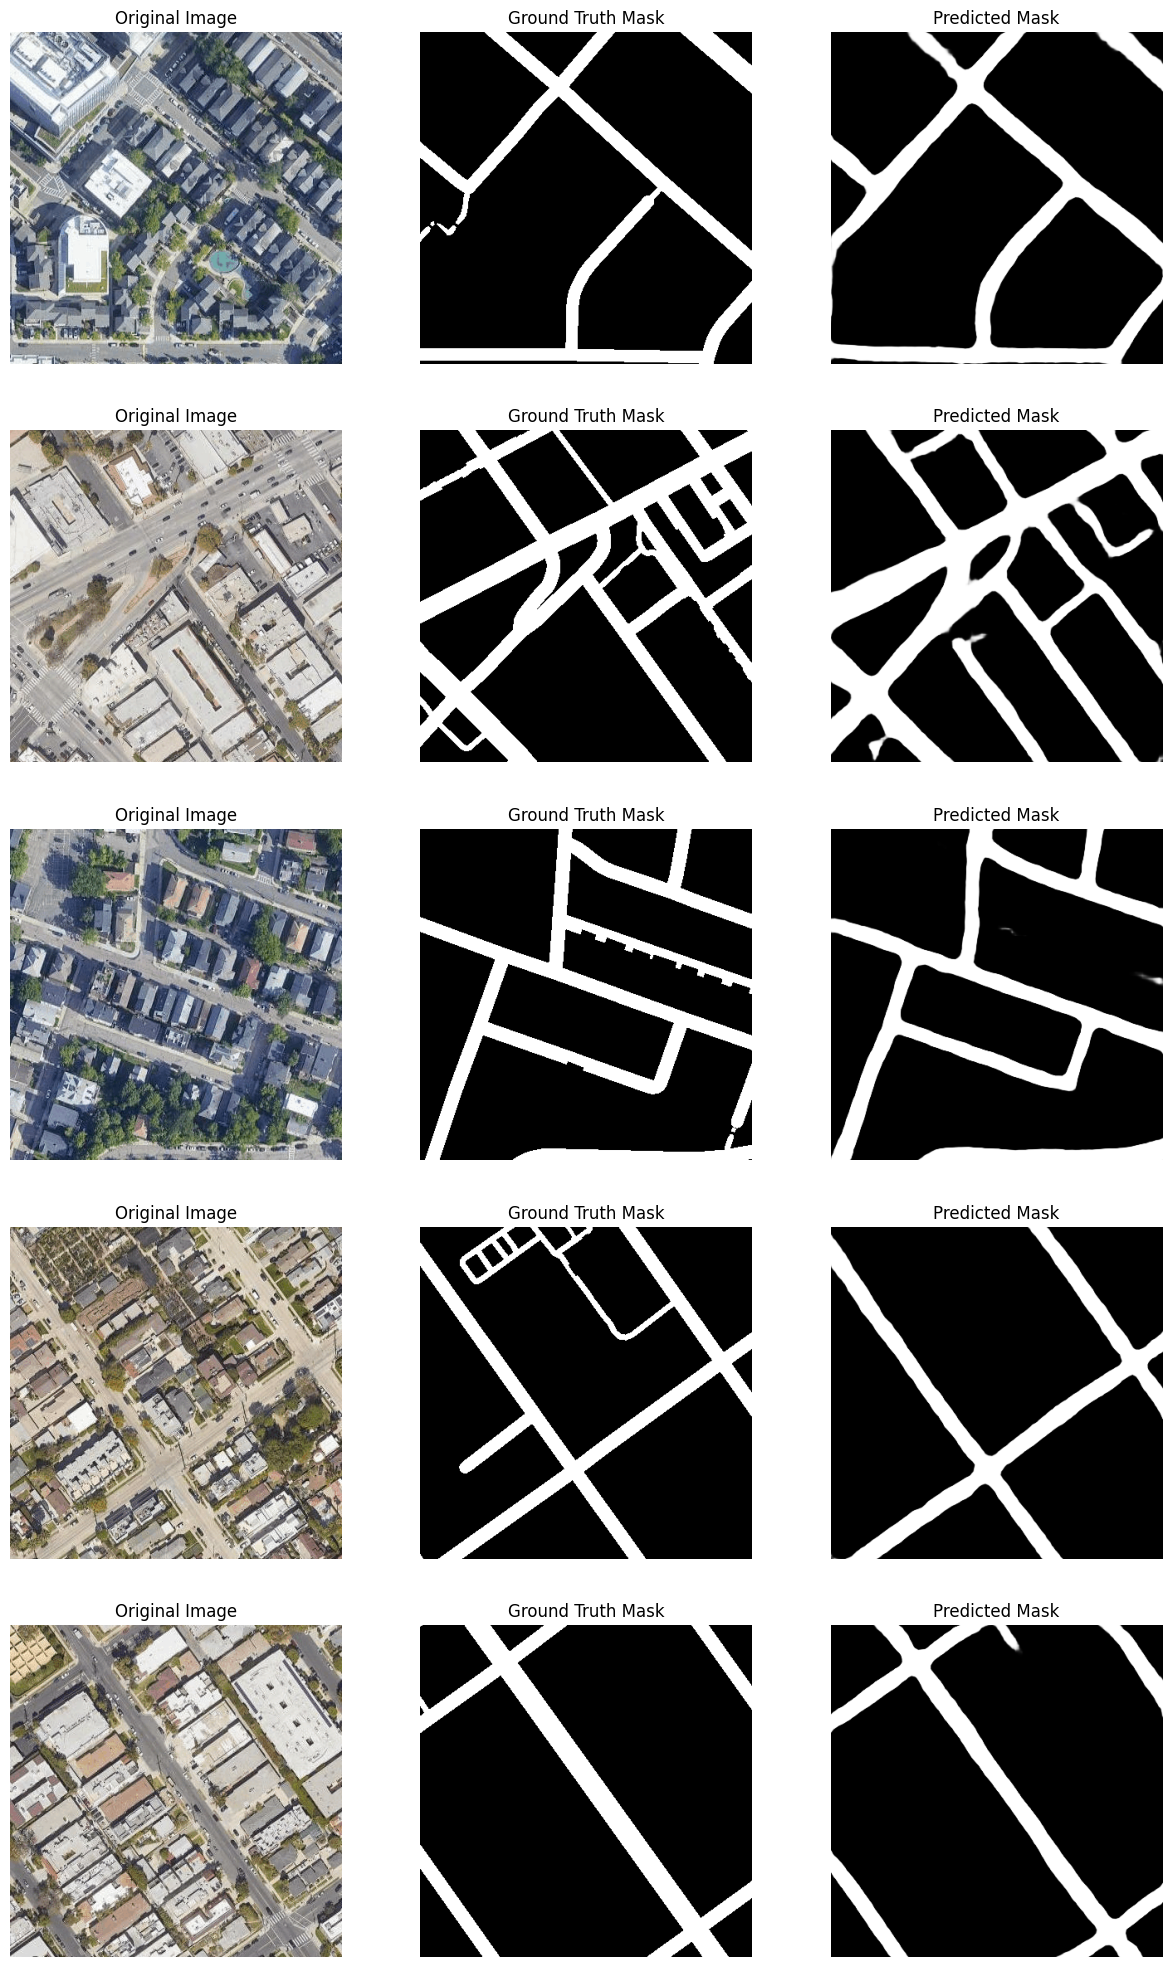

In [10]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

ori_X_val_tensor = torch.tensor(ori_val_x, dtype=torch.float32).permute(0, 3, 1, 2)
ori_Y_val_tensor = torch.tensor(ori_val_y, dtype=torch.float32).permute(0, 3, 1, 2)

# Create TensorDataset and DataLoader
val_dataset = TensorDataset(ori_X_val_tensor, ori_Y_val_tensor)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Function to visualize the predictions
def visualize_predictions(model, val_loader, device, num_images=5):
    model.eval()  # Set model to evaluation mode
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    
    with torch.no_grad():  # Disable gradient computation
        for i, (images, masks) in enumerate(val_loader):
            images = images.to(device)
            masks = masks.to(device)
            predictions = model(images)
            
            for j in range(min(num_images, images.size(0))):
                image = images[j].cpu().permute(1, 2, 0).numpy()
                mask = masks[j].cpu().permute(1, 2, 0).numpy()
                prediction = predictions[j].cpu().permute(1, 2, 0).numpy()
                
                # Plot original image
                axes[j, 0].imshow(image)
                axes[j, 0].set_title("Original Image")
                axes[j, 0].axis('off')
                
                # Plot ground truth mask
                axes[j, 1].imshow(mask, cmap='gray')
                axes[j, 1].set_title("Ground Truth Mask")
                axes[j, 1].axis('off')
                
                # Plot predicted mask
                axes[j, 2].imshow(prediction, cmap='gray')
                axes[j, 2].set_title("Predicted Mask")
                axes[j, 2].axis('off')
            
            if i + 1 >= num_images // images.size(0):
                break

# Visualize the predictions
best_model = torch.load('./best_model.pth', map_location='cuda')
visualize_predictions(best_model, val_loader, 'cuda', num_images=5)


In [ ]:
import torch
from torchvision.transforms import functional as TF
from PIL import Image
import numpy as np
import os
import segmentation_models_pytorch as smp

# Define a function to read and preprocess images
def _read_image(path: str):
    image = Image.open(path).convert('RGB')
    image = image.resize((512, 512))  # Resize to the input size of your model
    image = TF.to_tensor(image)  # Convert to tensor
    return image

# Define a function to load and preprocess test data
def get_preprocessed_test_data(path: str):
    """Load and preprocess the test data.

    Args:
        path (str): The path to the test data.

    Returns:
        np.ndarray: The preprocessed test data.
    """
    test_x_files = sorted([filename for filename in os.listdir(path) if filename.endswith('.png')])
    print(test_x_files)
    test_x = torch.stack([_read_image(f'{path}/{filename}') for filename in test_x_files])
    return test_x, test_x_files

# Load the model
model = torch.load('./best_model.pth', map_location=DEVICE)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Load and preprocess test data
X_test, X_test_files = get_preprocessed_test_data('/workspace/Comp/Datasets/Project/test/images')
X_test = X_test.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Make predictions
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()

# Ensure the predictions are of shape (height, width) before converting to images
y_pred = (y_pred > 0.5).astype(np.uint8).squeeze(axis=1)  # Squeeze the channel dimension if necessary

# Convert predictions to images and resize
pred_images = [Image.fromarray((y_pred[i] * 255)).resize((400, 400)) for i in range(y_pred.shape[0])]

# Ensure the output directory exists
output_path = '/workspace/Comp/Road-Segmentation-Comp/outputs'
os.makedirs(output_path, exist_ok=True)

# Save all images in the output_path directory
for i, img in enumerate(pred_images):
    img.save(f'{output_path}/pred_{X_test_files[i]}')

print("Images have been successfully saved.")
